## An exploration of the World Bank's [Sovereign Environmental, Social, and Governance](https://esgdata.worldbank.org/data/framework?lang=en) dataset.

The main drive for this project is to manipulate, explore, and visualize Worldbank's data.

My curiosity with this data is derived from it's near-global inclusion of countries. However, I am wary of how much decision-power it holds. As a budding data professional, It's my duty to understand the relationship between data and their many "truths".

I hold a philosophical stance that data science is missing value by extracting narratives from datasets. Often, I recall spending days staring up at Yosemite's 2000 foot granite walls. After many days, a noticable shift occured in my perception, and I began to *feel* the vastness of the rock that my mind had been compressing. I would like to see decision-makers regard data this way. I feel well-crafted, high quality data plots have more to offer decision-makers than we realize.

In [3]:
### Setup ###
from csv import reader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat

from pandasql import *
#! pip install psycopg2-binary

filepath = "/Users/zachpolitz/Desktop/WorldBank_ESG.csv"

### Open data file ###
ESG_opened = open(filepath)
ESG_read_csv = pd.read_csv(ESG_opened)
ESG_raw = pd.DataFrame(ESG_read_csv)
ESG_cols = ESG_raw.columns

In [4]:
### Move '1961' after '1960' ###
sixty_one = ESG_raw['1961']
ESG_raw.drop(['1961'], axis = 1,inplace = True)
ESG_raw.insert(loc = 5, column = '1961', value = 0)
ESG_raw['1961'] = sixty_one

### Drop unused columns ###
ESG_raw = ESG_raw.drop(['Country Code','Indicator Code','2050'], axis = 1)

### Extract header from first row of data ###

### Separate country and regional data ###
ESG_by_country = ESG_raw.iloc[3082:]
ESG_by_region = ESG_raw.iloc[0:3082]

### First, I'll get a basic overview of the dataset: 

In [5]:
ESG_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16013 entries, 0 to 16012
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    16013 non-null  object 
 1   Indicator Name  16013 non-null  object 
 2   1960            1356 non-null   float64
 3   1961            1955 non-null   float64
 4   1962            2192 non-null   float64
 5   1963            1966 non-null   float64
 6   1964            1978 non-null   float64
 7   1965            2017 non-null   float64
 8   1966            2018 non-null   float64
 9   1967            2260 non-null   float64
 10  1968            2037 non-null   float64
 11  1969            2048 non-null   float64
 12  1970            3084 non-null   float64
 13  1971            3589 non-null   float64
 14  1972            3833 non-null   float64
 15  1973            3585 non-null   float64
 16  1974            3596 non-null   float64
 17  1975            3935 non-null  

### Immediately I notice a number of things:
- Data collection occured from 1960 to 2020
- All data types are floats (decimals)
- The number of non-null data points (reported metrics) increases steadily until 2015, at which time reporting drops dramatically.

In [6]:
print(ESG_raw.head())
print('\n')
print(ESG_raw.tail())

  Country Name                                     Indicator Name  1960  \
0   Arab World  Access to clean fuels and technologies for coo...   NaN   
1   Arab World            Access to electricity (% of population)   NaN   
2   Arab World  Adjusted savings: natural resources depletion ...   NaN   
3   Arab World  Adjusted savings: net forest depletion (% of GNI)   NaN   
4   Arab World                 Agricultural land (% of land area)   NaN   

        1961       1962       1963       1964       1965       1966  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4  27.835643  27.826564  27.845522  27.847925  27.866972  27.866171   

        1967  ...       2011       2012       2013       2014       2015  \
0        NaN  ...  82.783218  83.120096  83.53

### Looking at the first and last rows, it appears that data were collected for regions, as well as individual countries. I also see that some values were filled in with 'NaN' or "Not a Number". 

Next step: Extract query-able terms
- Split the dataset into countries and regions. 
- Get all unique years
- Get all unique regions
- Get all unique countries
- Get all unique indicators 

In [7]:
### Separate country and regional data 
ESG_by_country = ESG_raw.iloc[3082:]
ESG_by_region = ESG_raw.iloc[0:3082]

In [8]:
### Create lists of unique years, indicies, and countries 
ESG_indicies = ESG_raw['Indicator Name'].unique()
ESG_years = ESG_raw.columns[2:] # get all columns except'Country Name' and 'Indicator Name'.
ESG_countries = ESG_by_country['Country Name'].unique()
ESG_regions = ESG_by_region['Country Name'].unique()

### I want to take a closer look at the distribution of Null values, or reporting volume.

To do so, I will create three dictionaries:
- 1st   {country: {year: sum_across_indicies(nulls) }}
- 2nd   {region: {year: sum_across_indicies(nulls) }}
- 3rd   {index: {year: sum_across_countries(nulls) }}

In [9]:
### Reporting activity/ null counts {country: year: sum_across_indicies(nulls)} ###
annual_null_counts = {}

for country in ESG_countries: 
    year_raw = ESG_by_country[ESG_by_country['Country Name'] == country]
    year_nulls = {}
    for year in ESG_years:
        nulls = 0
        years_data = year_raw[year]
        for indx in years_data:
            indx = str(indx)
            # data type is float, but value prints 'nan'
            if indx == 'nan':
                nulls += 1
        year_nulls[year] = nulls
    annual_null_counts[country] = year_nulls


In [10]:
### Reporting density dictionary: {region: year: sum_across_indicies(nulls)} ###
annual_null_counts_region = {}
for region in ESG_regions: 
    year_raw = ESG_by_region[ESG_by_region['Country Name'] == region]
    year_nulls = {}
    for year in ESG_years:
        nulls = 0
        years_data = year_raw[year]
        for indx in years_data:
            indx = str(indx)
            if indx == 'nan':
                nulls += 1
        year_nulls[year] = nulls
    annual_null_counts_region[region] = year_nulls

In [11]:
### Reporting density dictionary: {index: year: sum_across_countries(nulls)}

index_nulls_annual_sum = {}
for indx in ESG_indicies:
    index_nulls_annual_sum[indx] = {}
    d_set = ESG_by_country[ESG_by_country['Indicator Name'] == indx] # One index
    for year in ESG_years:  # One year
        d_vec = d_set[year]
        d = 0
        for row in d_vec: # One country
            if str(row) == 'nan': # Is the value null?
                d+= 1
        index_nulls_annual_sum[indx][year]= d

### Plotting nulls:
1. Scatter plot: the number of metrics measured across regions, per year.
2. Scatter plot: the number of metrics measured across countries, per year.

2. Create a line plot of metrics measured by each country, per year.

2806 46


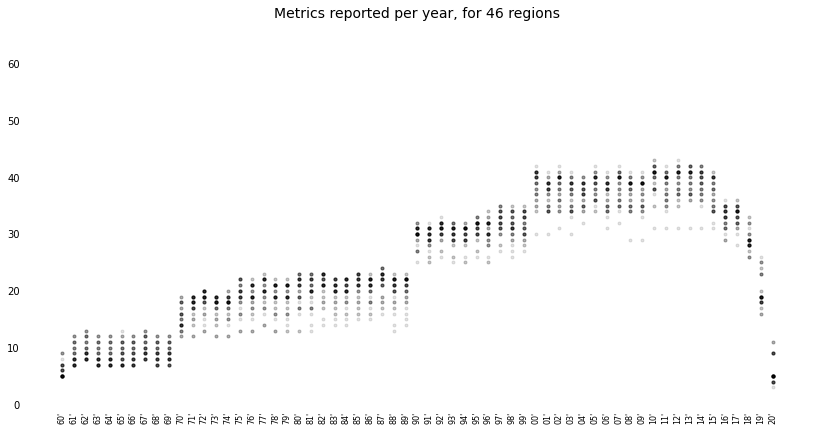

In [12]:
### number of reported metrics for each region, by year.

x=[]
y=[]

for year in ESG_years:
    for region in ESG_regions:
        year_string = str(year)
        x.append(year_string[-2:] + "'")
        y.append(67-annual_null_counts_region[region][year])

print(len(y),len(ESG_regions))
fig, ax = plt.subplots()

fig.set_figwidth(14)
fig.set_figheight(7)

ax.set_title("Metrics reported per year, for 46 regions",fontsize = 14)
ax.set_ylabel("")
ax.tick_params(axis = 'x',labelsize = 8, bottom=False, rotation = 90)
ax.tick_params(axis = 'y', left=False)

ax.set_ylim(top=67)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.scatter(x,y,marker = '.',c = 'black',alpha=.11)

plt.show()

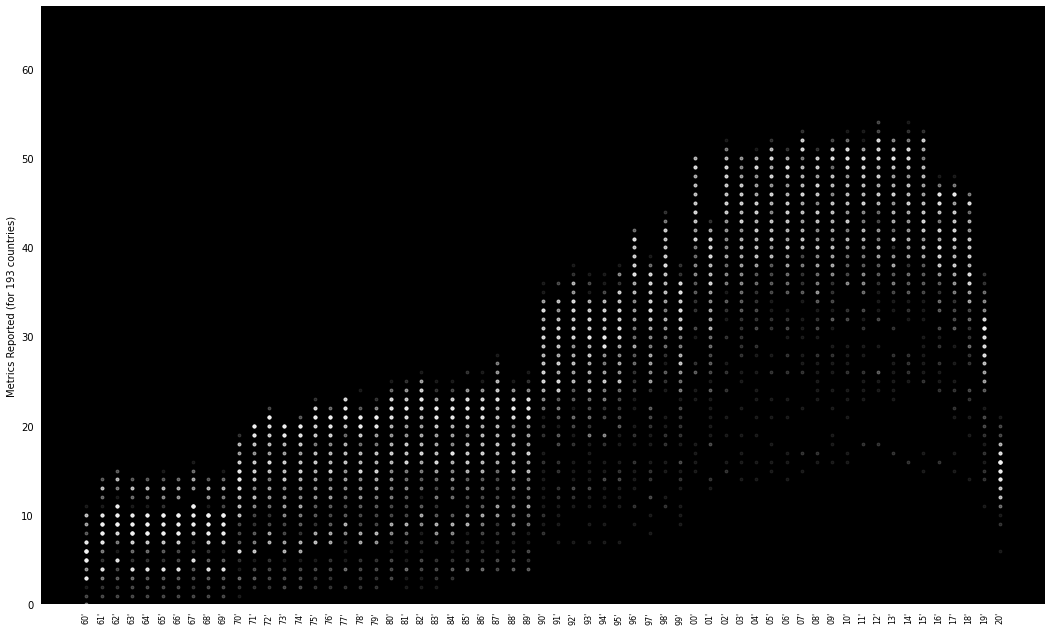

In [13]:
### number of reported metrics for each country, by year.

x=[]
y=[]

for year in ESG_years:
    for country in ESG_countries:
        year_string = str(year)
        x.append(year_string[-2:] + "'")
        y.append(67-annual_null_counts[country][year])
 
    
fig, ax = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(11)

ax.set_ylim(top=67)
ax.set_ylabel("Metrics Reported (for 193 countries)")

ax.tick_params(axis = 'x',labelsize = 8, bottom=False, rotation = 90)
ax.tick_params(axis = 'y', left=False)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_facecolor('black')
ax.scatter(x,y,marker = '.',c='white', alpha = .08)



plt.show()

A few things come to mind:

- I like the feeling of not having a legend-- it forces me to just feel the data as opposed to mapping it.
- It feels rich, with a simple complexity.


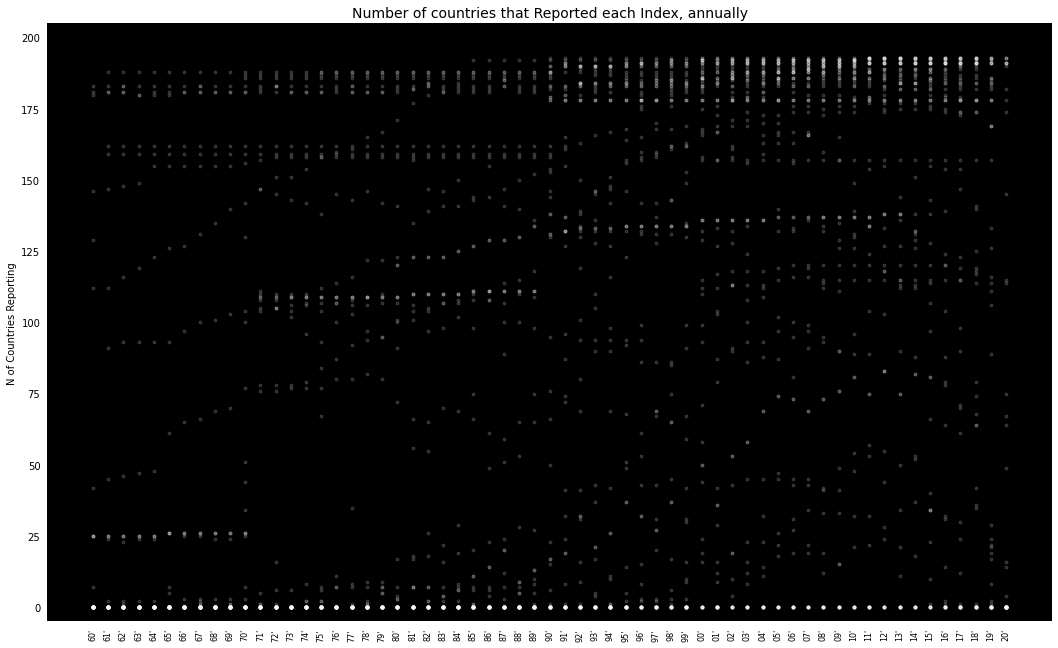

In [19]:
# plot volume of reporting for each metric, by year.

x=[]
y=[]

for year in ESG_years:
    for indx in ESG_indicies:
        year_string = str(year)
        x.append(year_string[-2:] + "'")
        y.append(193-index_nulls_annual_sum[indx][year])
        
fig, ax = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(11)

ax.set_title("Number of countries that Reported each Index, annually",fontsize = 14)

ax.set_ylim(top=205, bottom = -5)
ax.set_ylabel("N of Countries Reporting")
ax.tick_params(axis = 'x',labelsize = 8, bottom=False, rotation = 90)
ax.tick_params(axis = 'y', left=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_facecolor('black')
ax.scatter(x,y,marker = '.',c='white', alpha = .15)



plt.show()

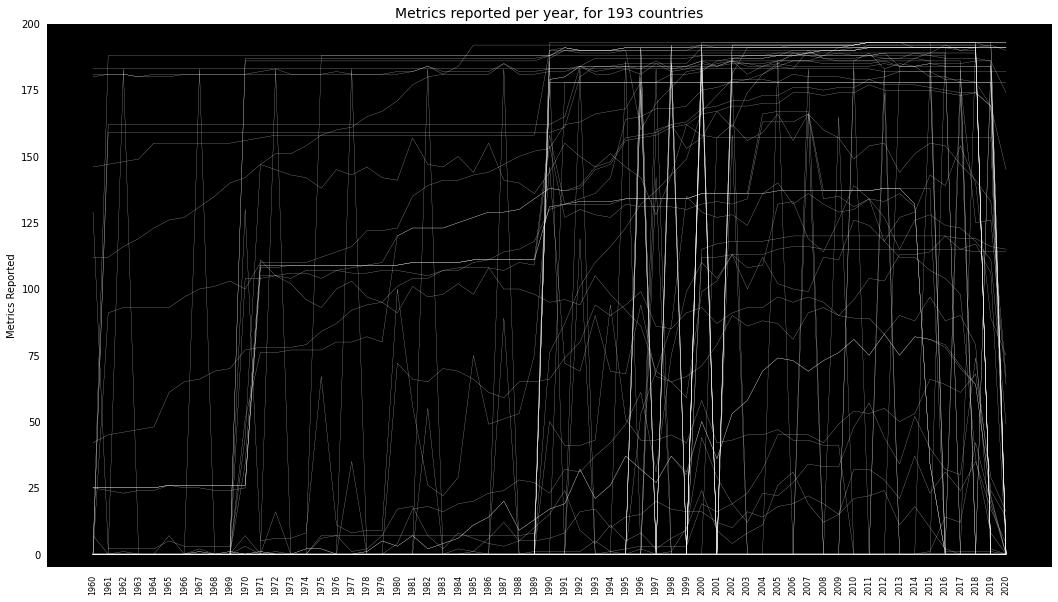

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(10)
ax.set_ylim(top=200,bottom = -5)
ax.set_ylabel("Metrics Reported")
ax.tick_params(axis = 'x',labelsize = 8, bottom=False, rotation = 90)
ax.tick_params(axis = 'y', left=False)

ax.set_title("Metrics reported per year, for 193 countries",fontsize = 14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

index_count = 0
for indx in ESG_indicies:
    x = []
    y = []
    for year in ESG_years:
        d = index_nulls_annual_sum[indx][year]
        x.append(193 - d)
        y.append(year)
    ax.plot(y,x, c = 'white', lw = .2)

ax.set_facecolor('black')
   

### Patterns:
- many metrics were recorded in cycles greater than once a year (every other year, every five years, etc.).
- There are metrics that have consistently recieved reporting, and some that have poor adherence.
- A handfull of metrics have had high levels of reporting since the beginning.

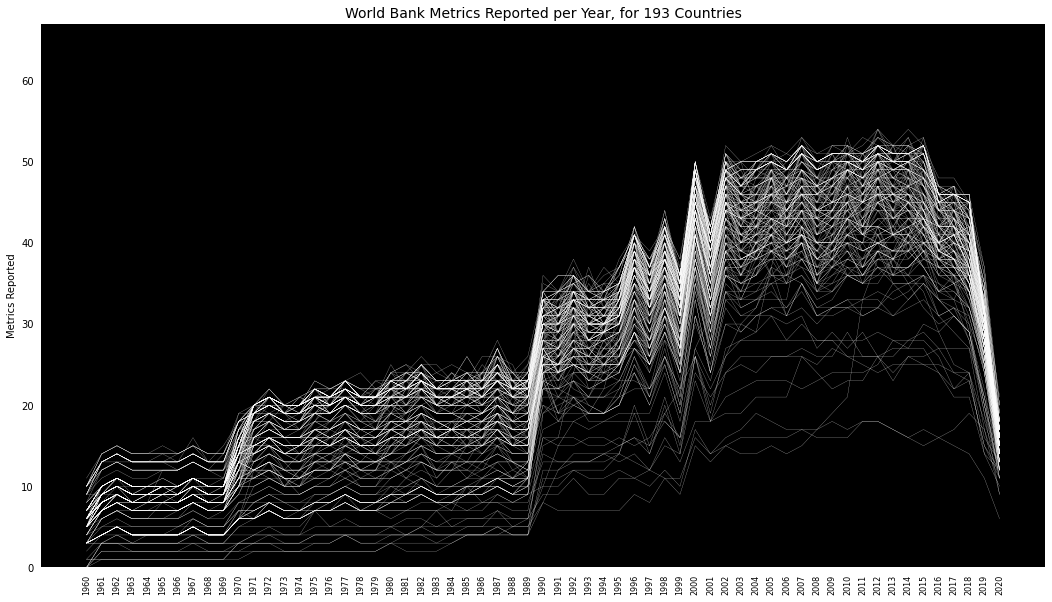

In [16]:
### Plot Line Graph for every country's number of metrics reported

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(10)
ax.set_ylim(top=67)
ax.set_ylabel("Metrics Reported")
ax.tick_params(axis = 'x',labelsize = 8, bottom=False, rotation = 90)
ax.tick_params(axis = 'y', left=False)

ax.set_title("World Bank Metrics Reported per Year, for 193 Countries",fontsize = 14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

country_count = 0
for country in ESG_countries:
    x = []
    y = []
    for year in ESG_years:
        d = annual_null_counts[country][year]
        x.append(67 - d)
        y.append(year)
    ax.plot(y,x, c = 'white', lw = .2)
    country_count += 1
ax.set_facecolor('black')

### Insights:

- World bank has made movements as an organization that influence the metrics recoreded by all countries: 69'-71',89', 95'-03', 15'-20'
- While reporting volume increased over the years, it became much more chaotic after the nineties. 
- There have always been a layer of countries that were reporting some metrics, but not all of the metrics offfered.
- The World Bank lists 67 different metrics, but never recieved over 55 inputs.

### Now let's get into the data!!

I am working to build proficiency with SQL, so I will be extracting my data using the pandasql library.

In [17]:
sql_ESG_countries = sqldf("""
SELECT * FROM ESG_by_country E
WHERE E.'Country Name' LIKE "United States"
""", globals())

sql_ESG_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    67 non-null     object 
 1   Indicator Name  67 non-null     object 
 2   1960            10 non-null     float64
 3   1961            13 non-null     float64
 4   1962            14 non-null     float64
 5   1963            13 non-null     float64
 6   1964            13 non-null     float64
 7   1965            14 non-null     float64
 8   1966            13 non-null     float64
 9   1967            14 non-null     float64
 10  1968            13 non-null     float64
 11  1969            13 non-null     float64
 12  1970            18 non-null     float64
 13  1971            19 non-null     float64
 14  1972            20 non-null     float64
 15  1973            19 non-null     float64
 16  1974            21 non-null     float64
 17  1975            20 non-null     float

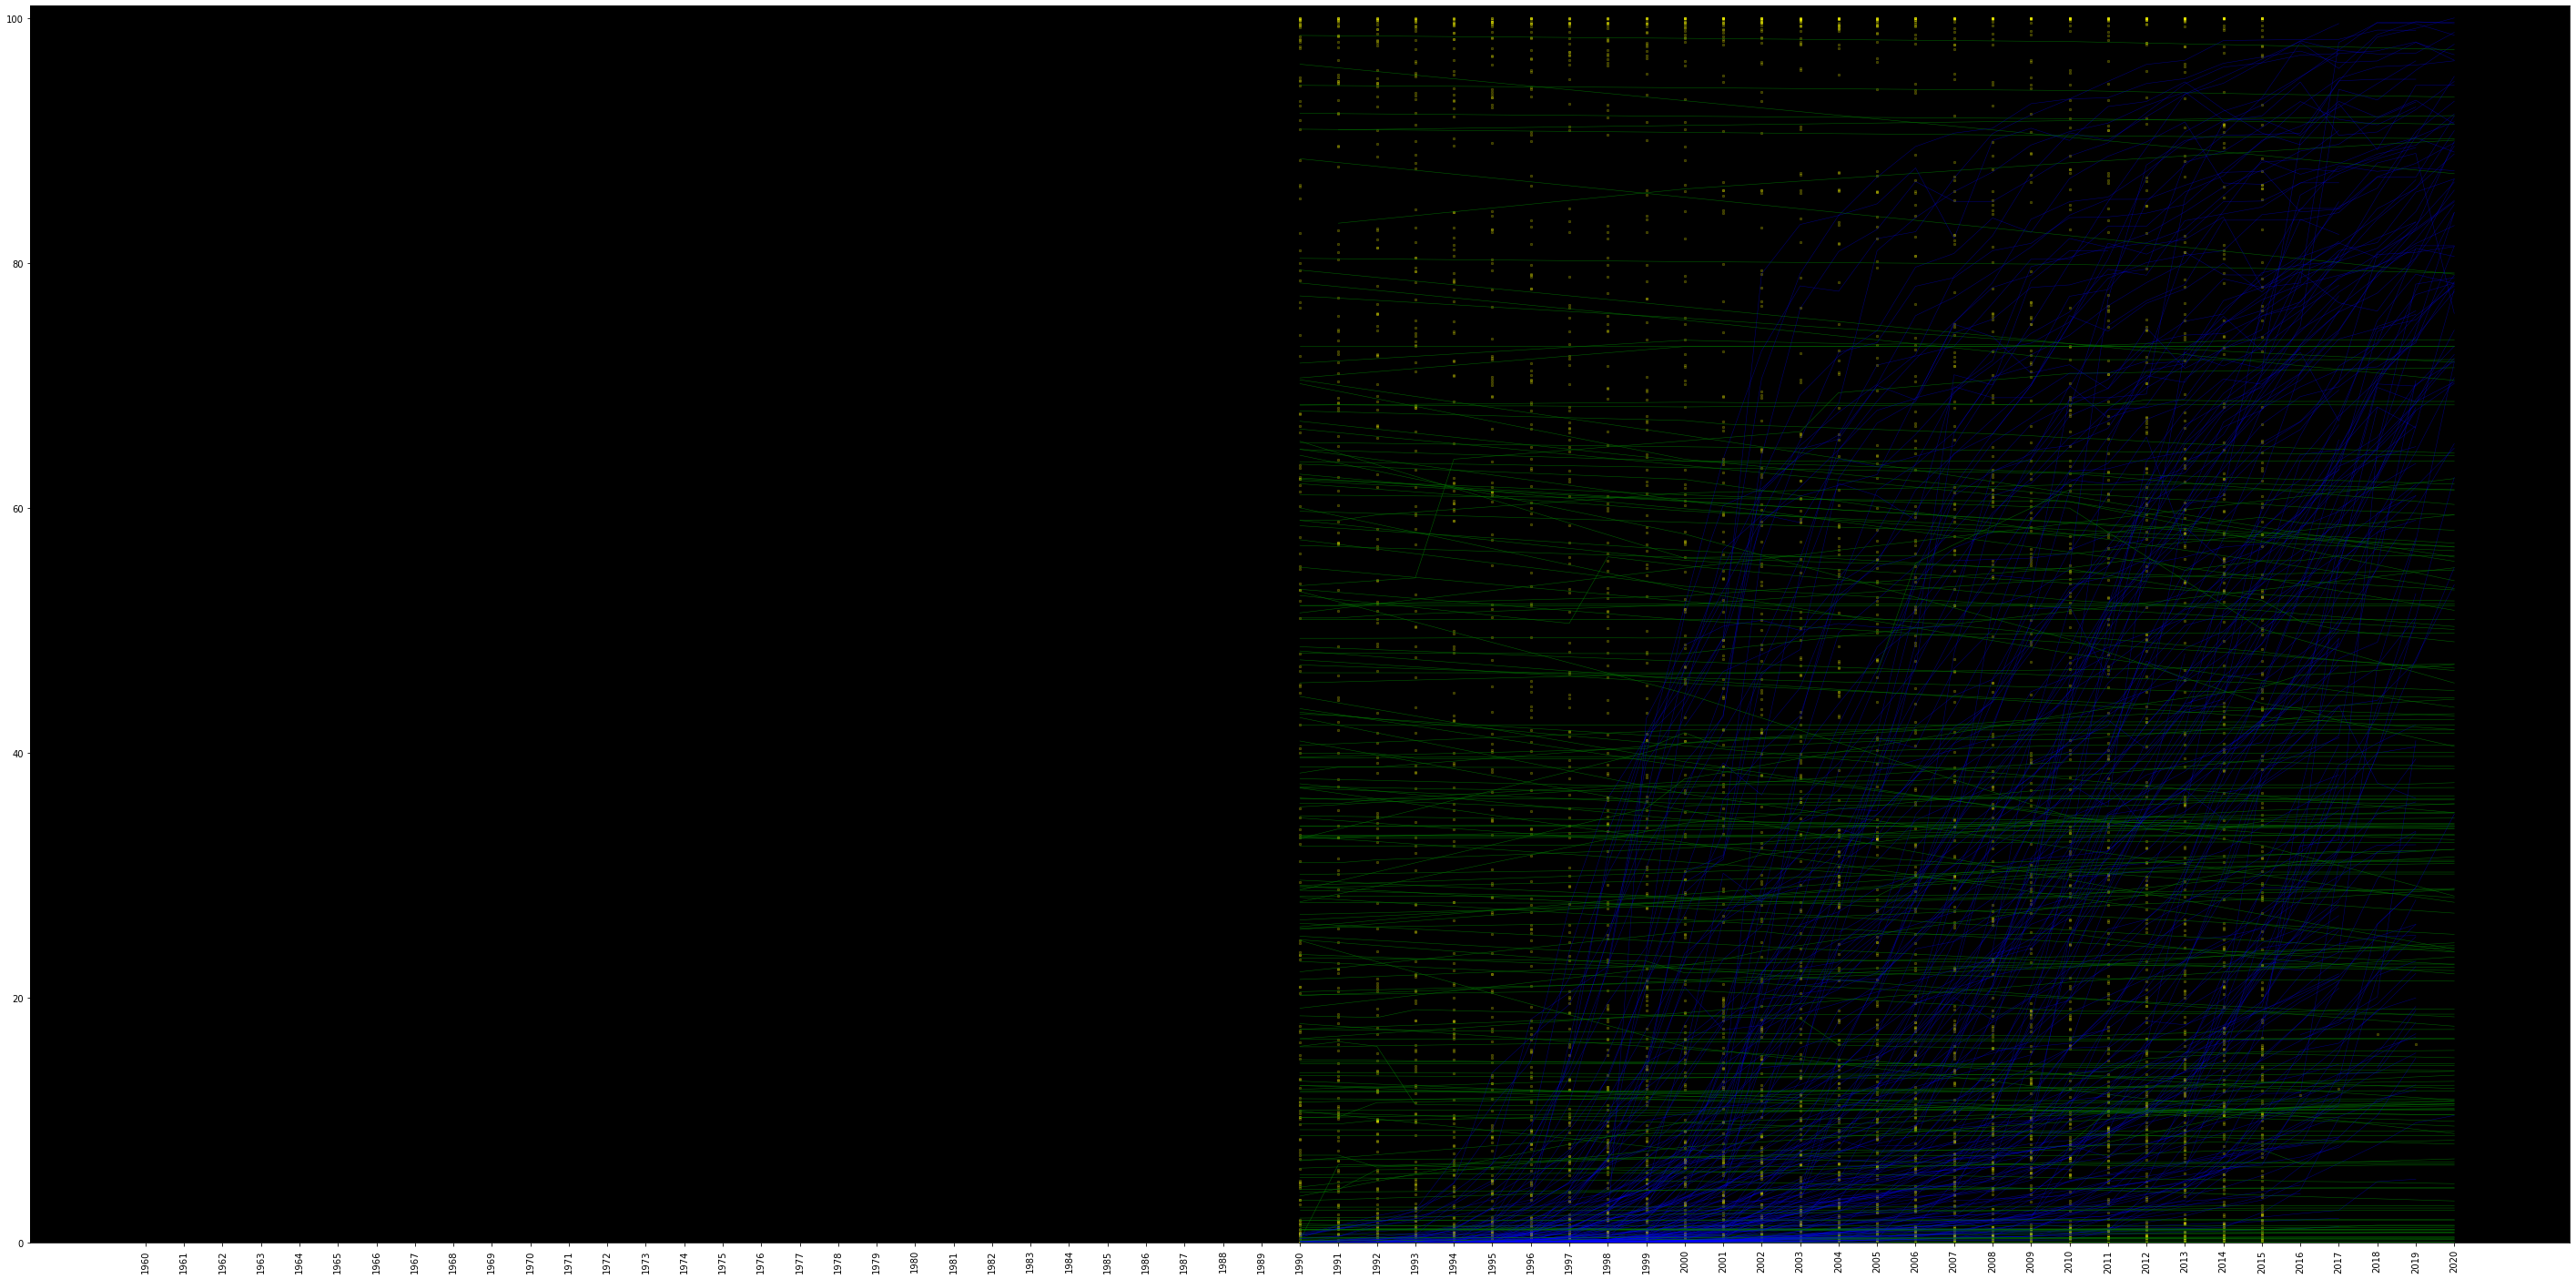

In [22]:
# Internet, renewables, pop_den

c_water = ESG_by_country[ESG_by_country['Indicator Name'] == 'People using safely managed drinking water services (% of population)']
forested = ESG_by_country[ESG_by_country['Indicator Name'] == 'Forest area (% of land area)']
# one year of inputs: mammals_threat = ESG_by_country[ESG_by_country['Indicator Name'] == 'Mammal species, threatened']
hunger = ESG_by_country[ESG_by_country['Indicator Name'] == 'Prevalence of undernourishment (% of population)']
poverty = ESG_by_country[ESG_by_country['Indicator Name'] == 'Poverty headcount ratio at national poverty lines (% of population)']
life_expec = ESG_by_country[ESG_by_country['Indicator Name'] == 'Life expectancy at birth, total (years)']
internet = ESG_by_country[ESG_by_country['Indicator Name'] == 'Individuals using the Internet (% of population)']
renewable = ESG_by_country[ESG_by_country['Indicator Name'] == 'Renewable electricity output (% of total electricity output)']
density = ESG_by_country[ESG_by_country['Indicator Name'] == 'Population density (people per sq. km of land area)']
countries = ESG_countries

fig, ax = plt.subplots()
fig.set_figwidth(50)
fig.set_figheight(25)
ax.tick_params(axis = 'x',rotation = 90)

fill_x = []
fill_y = []
for row in ESG_years:
    fill_x.append(row)
    fill_y.append(0)

    
for country in countries:
    f = forested[forested['Country Name'] == country]
    i = internet[internet['Country Name'] == country]
    r = renewable[renewable['Country Name'] == country]
    
    f_plot = []
    i_plot = []
    r_plot = []
    for year in ESG_years:
        f_plot.append(f[year])
        i_plot.append(i[year])
        r_plot.append(r[year])
    
    ax.scatter(fill_x,fill_y,alpha = 0)
    ax.plot(fill_x,f_plot, c = 'green', lw = .5, alpha = .8)
    ax.plot(fill_x,i_plot, c = 'blue', lw = .5, alpha = .5)
    ax.scatter(fill_x, r_plot, marker = ',', c = 'yellow', s = 5, alpha = .2)

ax.set_ylim(0,101)
ax.set_facecolor('black')

